<a href="https://colab.research.google.com/github/dgarciabtte/ecommerce/blob/main/Prompt_Engineering_with_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompt Engineering with Diffusion Models (Text to Image Generation)

This notebook provides tooling to explore prompt engineering: creating precise and informative instructions to acquire desired outputs from Diffusion models, using Hugging Face Diffusion Pipelines.

This notebook is a compliment to [Diffusion Bench](https://github.com/losandes/diffusion-bench), is simpler than Diffusion Bench (this runs in the cloud and doesn't run batches), and is easy to modify. The README for Diffusion Bench provides examples that compliment this notebook, so if you're interested in this notebook, you should check that out too.

If you aren't familiar with Hugging Face, text-to-image generation, or Diffusion models, the [Hugging Face NLP Course](https://huggingface.co/learn/nlp-course/chapter0/1) is a helpful introduction to what is explored here.

_Note that GPUs are a limited resource, both in what is allocated to you and how long you can use them. Google doesn't provide much insight as to the limitations or when you are nearing your limits. I actually ran out of resources writing this notebook!_

## Setup

**IMPORTANT: You need to run the Code in each section, in the order that it appears, each time you connect to a runtime.**

To get started with this notebook, click "File", and "Save a copy" to a location of your choosing.

This is an Image to Text notebook, so choose the T4 GPU (top right corner, click the down arrow next to RAM and Disk, choose "change runtime type", and choose T4 GPU).

Expect different results from different processors. So if you choose something other than a T4 GPU, or if that is no longer available, the storylines at the bottom (try this... then that) may not make sense.

The cell in this section installs the python packages that are used in this notebook.

In [1]:
!pip install transformers[sentencepiece]
!pip install diffusers --upgrade
!pip install invisible_watermark accelerate safetensors ipyplot torch scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.3 MB/s eta 0:00:00


## Predictable Tensor Generation

To explore the effects of changing prompts and variables, we need to be able to repeat results.

This notebook uses [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html) to generate a tensor filled with random numbers. It uses [torch.Generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to manage random number generation so that we can produce predictable tensors when providing a manual seed.[^1]

These tensors will then be passed as an argument to the Diffusion Pipeline.

[^1]: You can read more about generating tensors in [Using torch.randn and torch.randn_like to create Random Tensors in PyTorch](https://machinelearningknowledge.ai/using-torch-randn-and-torch-randn_like-to-create-random-tensors-in-pytorch/)

In [12]:
import torch

NONE = None

def make_latents (
  device,
  in_channels,
  width=768,
  height=768,
  seed=NONE,
):
  """
  @see https://colab.research.google.com/github/pcuenca/diffusers-examples/blob/main/notebooks/stable-diffusion-seeds.ipynb
  """
  # print(f"device: {device}")
  # print(f"in_channels: {in_channels}")
  # print(f"width: {width}")
  # print(f"height: {height}")
  # print(f"seed: {seed}")
  # print(f"together: {(1, in_channels, height // 8, width // 8)}")

  generator = torch.Generator(device=device)
  seed = seed if seed is not None else generator.seed()
  generator = generator.manual_seed(seed)

  return [
    seed,
    torch.randn(
      (1, in_channels, height // 8, width // 8),
      generator = generator,
      device = device,
      dtype=torch.float16,
    ),
  ]

  # latents should have shape like (4, 4, 64, 64)
  # latents.shape


## Diffusion Pipelines

The image text-to-image generation is performed by Hugging Face Pipelines. The code in this section configures the pipelines that we'll use for image generation.

Two models are provided:

-   [Dreamlike Photoreal 2](https://huggingface.co/dreamlike-art/dreamlike-photoreal-2.0)
-   [Stable Diffusion XL Base](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)

Try adding another! (e.g. [Analog Diffusion](https://huggingface.co/wavymulder/Analog-Diffusion) or [Openjourney](https://huggingface.co/prompthero/openjourney))

_Note that, when adding a new pipeline, it's important to keep the same dtype (torch_dtype=torch.float16)_

### Dreamlike Photoreal 2

Create a pipeline that uses [Dreamlike Photoreal 2](https://huggingface.co/dreamlike-art/dreamlike-photoreal-2.0)

In [11]:
from diffusers import StableDiffusionPipeline
import torch

def dp2_pipeline (device):
  """
  @see https://huggingface.co/dreamlike-art/dreamlike-photoreal-2.0

  This model was trained on 768x768px images, so use:
  - 768x768px
  - 640x896px
  - 896x640px
  - 768x1024px
  - 1024x768px
  """
  model_id = "dreamlike-art/dreamlike-photoreal-2.0"
  pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    use_safetensors=True,
    torch_dtype=torch.float16,
  ).to(device)

  return [model_id, pipe]


### Stable Diffusion XL

Create a pipeline that uses [Stable Diffusion XL Base](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)

In [13]:
from diffusers import DiffusionPipeline

def sdxl_pipeline (device):
  """
  @see https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0
  """
  model_id = "stabilityai/stable-diffusion-xl-base-1.0"
  pipe = DiffusionPipeline.from_pretrained(
    model_id,
    use_safetensors=True,
    torch_dtype=torch.float16,
  ).to(device)

  return [model_id, pipe]


## Text to Image Generator

The code in this section composes the latent generation and pipeline execution to produce an image.



In [14]:
def txt2img (pipeline, device, manual_seed):
  """
  Produces a function that generates an image from text

  Returns: (prompt, width, height, manual_seed, **kwargs) => Image
  """

  def _txt2img (prompt, **kwargs):
    """
    Generates an image from text

    Returns: Image
    """

    if not 'width' in kwargs or kwargs['width'] is None:
      print(f"expected int, actual width: {kwargs['width']}")
      raise Exception("width is required")

    if not 'height' in kwargs or kwargs['height'] is None:
      print(f"expected int, actual height: {kwargs['height']}")
      raise Exception("height is required")

    [model_id, pipe] = pipeline(device)
    [seed, latents] = make_latents(
      device,
      pipe.unet.config.in_channels,
      width=kwargs['width'],
      height=kwargs['height'],
      seed=manual_seed,
    )

    result = pipe(
      prompt,
      latents=latents,
      **kwargs
    )

    return [result, model_id, seed]
  return _txt2img

## Practice Prompt Engineering

Following is the code you'll work with to explore prompt engineering with diffusion models. Look below the code for suggestions on how to get started.

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


PROMPT: a cute, australian sheppherd
NEGATIVE_PROMPT: extra noses, mangled faces
STEPS: 20
WIDTH: 896
HEIGHT: 640
DEVICE: cuda
MODEL_ID: dreamlike-art/dreamlike-photoreal-2.0
SEED: 4009664425088305



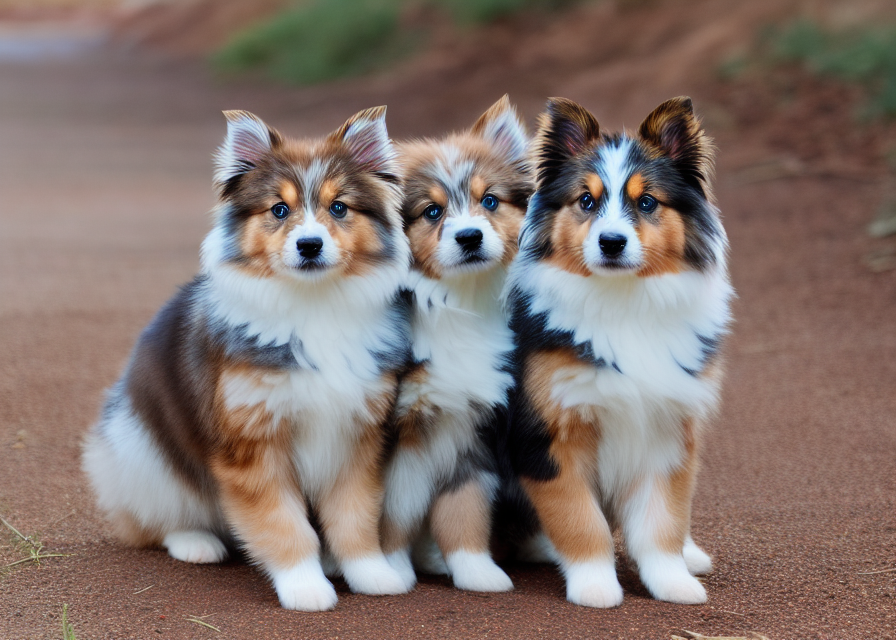

In [33]:
WIDTH           = 896
HEIGHT          = 640
STEPS           = 20 # try integers between 10 and 150
DEVICE          = "cuda"
 # use `None` as the value for SEED to generate a new seed
SEED            = 4009664425088305
PROMPT          = "a cute, australian sheppherd"
NEGATIVE_PROMPT = "extra noses, mangled faces"
GUIDANCE_SCALE  = 7.5
PIPELINE        = dp2_pipeline # dp2_pipeline | sdxl_pipeline

[result, model_id, seed] = txt2img(PIPELINE, DEVICE, SEED)(
  PROMPT,
  negative_prompt=NEGATIVE_PROMPT,
  num_inference_steps=STEPS,
  width=WIDTH,
  height=HEIGHT,
  guidance_scale=GUIDANCE_SCALE
)

print("")
print(f"PROMPT: {PROMPT}")
print(f"NEGATIVE_PROMPT: {NEGATIVE_PROMPT}")
print(f"STEPS: {STEPS}")
print(f"WIDTH: {WIDTH}")
print(f"HEIGHT: {HEIGHT}")
print(f"DEVICE: {DEVICE}")
print(f"MODEL_ID: {model_id}")
print(f"SEED: {seed}")
print("")
result.images[0]

### Refine with Prompts

How does changing a prompt change the image?

**Try**:

```py
STEPS           = 10
SEED            = 6886045143854674
PROMPT          = "a painting of a woman talking with a robot"
```

Fun... mangled hands though. Hands are difficult. We could try to remove them with negative prompts, but let's keep working on the prompt for now.

Add an artist, and change the number of steps to 20:

```py
STEPS           = 20
SEED            = 6886045143854674
PROMPT          = "a painting of a woman talking with a robot, by Alphonse Mucha"
```

In this example, adding the artist produces a significant change. Let's instruct it to change the style:

```py
STEPS           = 20
SEED            = 6886045143854674
PROMPT          = "a painting of a woman talking with a robot, intricate, elegant, trending on artstation, masterpiece, by Alphonse Mucha"
```

What happens if we change the artist now?

```py
STEPS           = 20
SEED            = 6886045143854674
PROMPT          = "a painting of a woman talking with a robot, intricate, elegant, trending on artstation, masterpiece, by Sam Spratt"
```




### Refine with Negative Prompts

How does a negative prompt change the image?

**Try**:

```py
SEED            = 129324426782117
PROMPT          = "a cute, tabby cat"
NEGATIVE_PROMPT = ""
```

**Followed by**:

```py
SEED            = 129324426782117
PROMPT          = "a cute, tabby cat"
NEGATIVE_PROMPT = "not blurry"
```

How does the negative prompt change the image?


**Try**:

```py
SEED            = 4009664425088305
PROMPT          = "a cute, tabby cat"
NEGATIVE_PROMPT = ""
```

Hmmm. We asked for one cat, but got two. They're cute, but they aren't what we asked for. Let's see if we can solve that with a negative prompt.

**Try**:

```py
SEED            = 4009664425088305
PROMPT          = "a cute, tabby cat"
NEGATIVE_PROMPT = "two cats, multiple cats"
```

Was this as effective as "not blurry" was in the previous attempts? A seed can be stubborn. How might we use that to our advantage?

**Try**:

```py
SEED            = 4009664425088305
PROMPT          = "a cute, australian sheppherd"
NEGATIVE_PROMPT = ""
```

Now there are even more animals! This seed likes groups. What's happening with the nose on the dog on the left?

**Let's see if we can fix that**:

```py
SEED            = 4009664425088305
PROMPT          = "a cute, australian sheppherd"
NEGATIVE_PROMPT = "extra noses, mangled faces"
```

awwwww

## Demonstrate What You Learned

Use the following cell to generate an image that you will refine. Once you find the image you will refine, move to the next code cell and leave the image in this cell, so I can see it when you share this notebook with me.

Consider adding notes / text cells to share any context you think is worth sharing or remembering.

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


PROMPT: Paint a woman running the Boston Marathon in 2015 by Botero
NEGATIVE_PROMPT: 
STEPS: 10
WIDTH: 896
HEIGHT: 640
DEVICE: cuda
MODEL_ID: dreamlike-art/dreamlike-photoreal-2.0
SEED: 4936021078491715



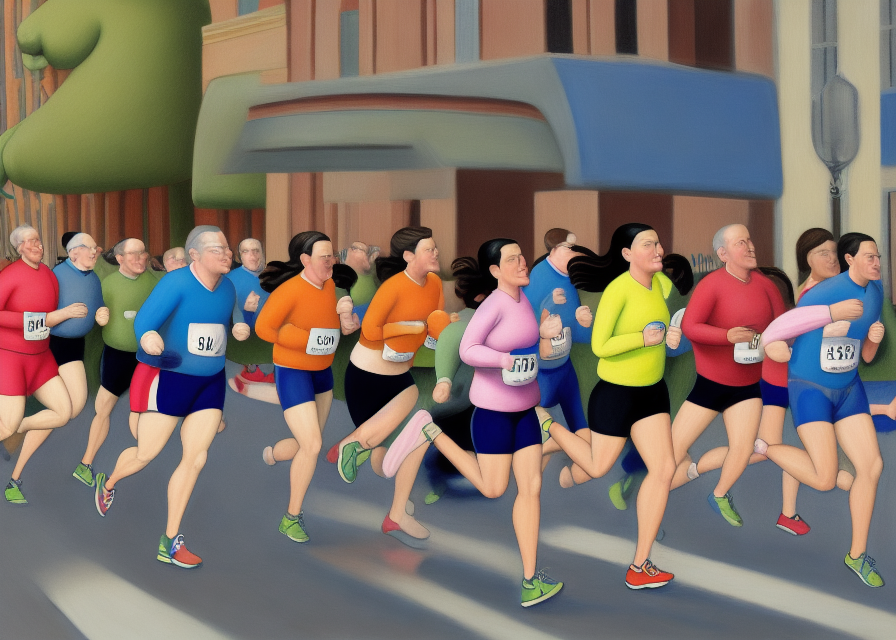

In [52]:
WIDTH           = 896
HEIGHT          = 640
STEPS           = 10 # try integers between 10 and 150
DEVICE          = "cuda"
 # use `None` as the value for SEED to generate a new seed
SEED            = None
PROMPT          = "Paint a woman running the Boston Marathon in 2015 by Botero"
NEGATIVE_PROMPT = ""
GUIDANCE_SCALE  = 7.5
PIPELINE        = dp2_pipeline # dp2_pipeline | sdxl_pipeline

[result, model_id, seed] = txt2img(PIPELINE, DEVICE, SEED)(
  PROMPT,
  negative_prompt=NEGATIVE_PROMPT,
  num_inference_steps=STEPS,
  width=WIDTH,
  height=HEIGHT,
  guidance_scale=GUIDANCE_SCALE
)

print("")
print(f"PROMPT: {PROMPT}")
print(f"NEGATIVE_PROMPT: {NEGATIVE_PROMPT}")
print(f"STEPS: {STEPS}")
print(f"WIDTH: {WIDTH}")
print(f"HEIGHT: {HEIGHT}")
print(f"DEVICE: {DEVICE}")
print(f"MODEL_ID: {model_id}")
print(f"SEED: {seed}")
print("")
result.images[0]

### Refine with Prompts

Using just the prompt, refine the image you generatedd above. Remember to set the seed. You can also change the number of steps and the guidance scale here, if you wish (the guidance scale instructs the model how much to follow your prompt).

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]


PROMPT: Paint a woman running the Boston Marathon in 2015 by Botero
NEGATIVE_PROMPT: 
STEPS: 40
WIDTH: 896
HEIGHT: 640
DEVICE: cuda
MODEL_ID: dreamlike-art/dreamlike-photoreal-2.0
SEED: 4936021078491715



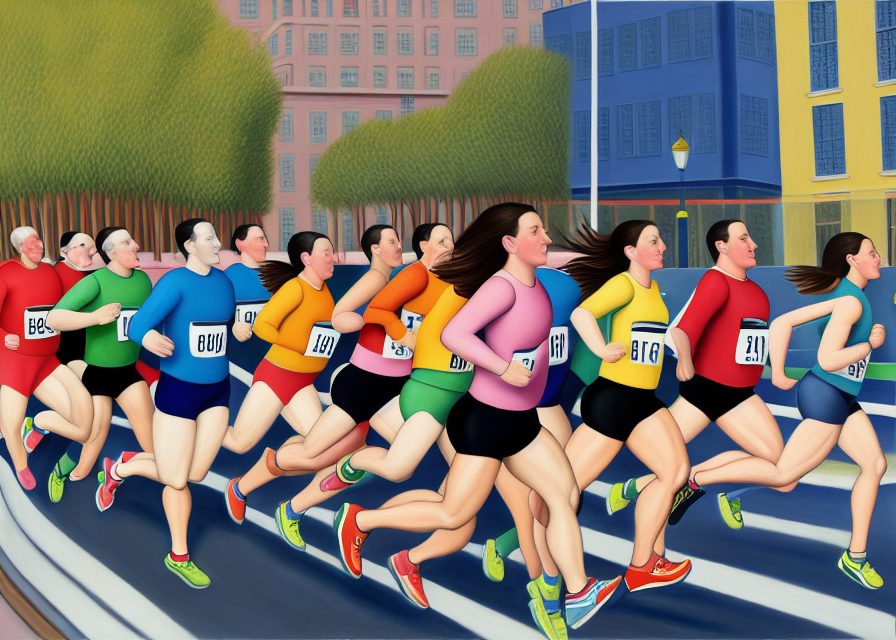

In [53]:
WIDTH           = 896
HEIGHT          = 640
STEPS           = 40 # try integers between 10 and 150
DEVICE          = "cuda"
 # use `None` as the value for SEED to generate a new seed
SEED            =4936021078491715
PROMPT          = "Paint a woman running the Boston Marathon in 2015 by Botero"
NEGATIVE_PROMPT = ""
GUIDANCE_SCALE  = 7.5
PIPELINE        = dp2_pipeline # dp2_pipeline | sdxl_pipeline

[result, model_id, seed] = txt2img(PIPELINE, DEVICE, SEED)(
  PROMPT,
  negative_prompt=NEGATIVE_PROMPT,
  num_inference_steps=STEPS,
  width=WIDTH,
  height=HEIGHT,
  guidance_scale=GUIDANCE_SCALE
)

print("")
print(f"PROMPT: {PROMPT}")
print(f"NEGATIVE_PROMPT: {NEGATIVE_PROMPT}")
print(f"STEPS: {STEPS}")
print(f"WIDTH: {WIDTH}")
print(f"HEIGHT: {HEIGHT}")
print(f"DEVICE: {DEVICE}")
print(f"MODEL_ID: {model_id}")
print(f"SEED: {seed}")
print("")
result.images[0]

### Refine with Negative Prompts

Using the negative prompt, further refine the image you generated above.

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]


PROMPT: Paint a woman running the Boston Marathon in 2015 by Botero
NEGATIVE_PROMPT: two women
STEPS: 60
WIDTH: 896
HEIGHT: 640
DEVICE: cuda
MODEL_ID: dreamlike-art/dreamlike-photoreal-2.0
SEED: 4936021078491715



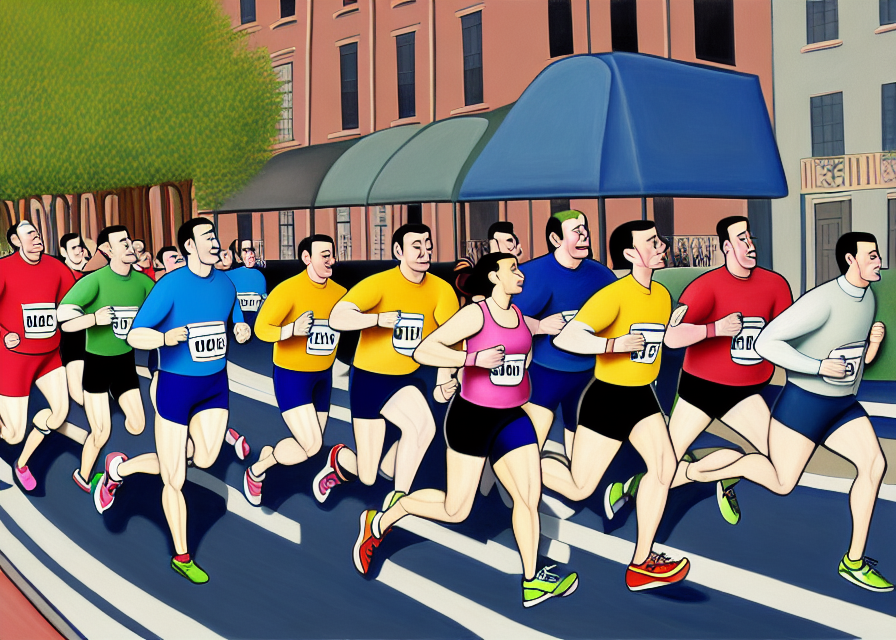

In [56]:
WIDTH           = 896
HEIGHT          = 640
STEPS           = 60 # try integers between 10 and 150
DEVICE          = "cuda"
 # use `None` as the value for SEED to generate a new seed
SEED            = 4936021078491715
PROMPT          = "Paint a woman running the Boston Marathon in 2015 by Botero"
NEGATIVE_PROMPT = "two women"
GUIDANCE_SCALE  = 7.5
PIPELINE        = dp2_pipeline # dp2_pipeline | sdxl_pipeline

[result, model_id, seed] = txt2img(PIPELINE, DEVICE, SEED)(
  PROMPT,
  negative_prompt=NEGATIVE_PROMPT,
  num_inference_steps=STEPS,
  width=WIDTH,
  height=HEIGHT,
  guidance_scale=GUIDANCE_SCALE
)

print("")
print(f"PROMPT: {PROMPT}")
print(f"NEGATIVE_PROMPT: {NEGATIVE_PROMPT}")
print(f"STEPS: {STEPS}")
print(f"WIDTH: {WIDTH}")
print(f"HEIGHT: {HEIGHT}")
print(f"DEVICE: {DEVICE}")
print(f"MODEL_ID: {model_id}")
print(f"SEED: {seed}")
print("")
result.images[0]